# Cassava Disease Classification

This notebook demonstrates an end-to-end workflow for **cassava leaf disease detection** using deep learning. It covers:

- Loading a **DenseNet121 PyTorch model** trained on cassava leaf images.
*(Trained using the [Cassava Leaf Disease Classification GitHub repository](https://github.com/ekbarkacha/cassava-disease-classification))*
- Exporting the model to **ONNX** for interoperability.
- Converting ONNX to **TensorFlow** and **TFLite** for mobile deployment.
- Running inference on **dummy data** or **real images**.
- Displaying input images with **predicted disease labels** and probabilities.

The notebook is optimized for easy experimentation and deployment, making it ideal for testing models on real-world cassava leaf images and preparing them for edge devices.


## Requirements
Imports all the necessary libraries.

In [ ]:
import os
import glob
import onnx
import torch
import numpy as np
from PIL import Image
import torch.nn as nn
import tensorflow as tf
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset
from onnx_tf.backend import prepare

import warnings
warnings.filterwarnings("ignore")

## Load Pytorch Model And Export to ONNX

In [13]:
# Load Pytorch Model
num_classes = 5

model = models.densenet121(pretrained=False)
model.classifier = nn.Linear(model.classifier.in_features, num_classes)

weights_path = "../models/DenseNet121.pth"
model.load_state_dict(torch.load(weights_path, map_location='cpu'))
model.eval()

# Export to ONNX
dummy_input = torch.randn(1, 3, 380, 380)
torch.onnx.export(model, 
                  dummy_input, 
                  "../models/model.onnx",
                  input_names=["input"], 
                  output_names=["output"],
                  dynamic_axes={"input": {0: "batch"}, "output": {0: "batch"}},
                  verbose=False)
print("ONNX model generated successfully.")

ONNX model generated successfully.


## Verify The Generated ONNX Model

Before converting to TFLite, make sure the ONNX model is valid: This ensures there are no structural errors.

In [14]:
# Verify the ONNX Model

onnx_model = onnx.load("../models/model.onnx")
onnx.checker.check_model(onnx_model)
print("ONNX model is valid!")


ONNX model is valid!


## Convert ONNX To TensorFlow Model

In [15]:
#Convert ONNX -> TensorFlow
onnx_model = onnx.load("../models/model.onnx")
tf_rep = prepare(onnx_model)
tf_rep.export_graph("../models/model_tf")

print("TensorFlow model generated successfully.")

INFO:absl:Function `__call__` contains input name(s) x, tensor with unsupported characters which will be renamed to transpose_368_x, reshape_247_tensor in the SavedModel.
INFO:absl:Found untraced functions such as gen_tensor_dict while saving (showing 1 of 1). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../models/model_tf/assets


INFO:tensorflow:Assets written to: ../models/model_tf/assets
INFO:absl:Writing fingerprint to ../models/model_tf/fingerprint.pb


TensorFlow model generated successfully.


## Convert TensorFlow Model To TFLite

In [16]:
# Convert TensorFlow -> TFLite
converter = tf.lite.TFLiteConverter.from_saved_model("../models/model_tf")
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

with open("../models/cassava_model.tflite", "wb") as f:
    f.write(tflite_model)

print("TFLite model generated successfully.")


2025-12-11 15:59:10.379647: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-12-11 15:59:10.379670: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-12-11 15:59:10.379906: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: ../models/model_tf
2025-12-11 15:59:10.390604: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-12-11 15:59:10.390620: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: ../models/model_tf
2025-12-11 15:59:10.414210: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2025-12-11 15:59:10.536015: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: ../models/model_tf
2025-12-11 15:59:10.649592: I tensorflow/cc/saved_model/loader.cc:314] SavedModel load for tags { serve }; Status: success: OK. Took 2

TFLite model generated successfully.


## Get The Size Of Generated TFLite 

In [17]:
# Get The TFLite Size
file_path = "../models/cassava_model.tflite"
size_bytes = os.path.getsize(file_path)
size_mb = size_bytes / (1024 * 1024)

print(f"File size: {size_mb:.2f} MB")

File size: 7.12 MB


## Verify The Generated TFLite Model

In [18]:
# Verify TFLite Model
interpreter = tf.lite.Interpreter(model_path="../models/cassava_model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

dummy_input = np.random.rand(1, 3, 380, 380).astype(np.float32)

interpreter.set_tensor(input_details[0]['index'], dummy_input)
interpreter.invoke()

pred = interpreter.get_tensor(output_details[0]['index'])
print("TFLite output shape:", pred.shape)

TFLite output shape: (1, 5)


## Verify TFLite Model With Actual Image

Now we performs **TFLite model inference on a real image** using the same preprocessing pipeline as the original PyTorch model.

**Steps:**

1. **Data Augmentation / Preprocessing**
   - Defines mean and standard deviation for normalization.
   - Applies `Resize(400)`, `CenterCrop(380)`, `ToTensor()`, and `Normalize(mean, std)` using `transforms.Compose`.
   - Ensures the image matches the expected input size and distribution of the trained model.

2. **Custom Dataset**
   - `TestDataset` class loads either a single image or all images in a folder.
   - Applies the preprocessing transforms to the image(s).

3. **Image Loading**
   - Loads a single image from disk using the dataset class.
   - Converts the PyTorch tensor to a NumPy array and adds a batch dimension for TFLite input `(1, 3, 380, 380)`.

4. **TFLite Inference**
   - Loads the TFLite model and allocates tensors.
   - Sets the preprocessed image as input and invokes the interpreter.
   - Converts logits to probabilities using **softmax**.
   - Determines the predicted class index and label.

5. **Visualization**
   - Plots the original image using `matplotlib`.
   - Displays the predicted class label as the plot title.

**Outcome:**  
Finally we output the **predicted disease label**, the **probabilities for all classes**, and a **visual display of the input image** for verification.

Predicted label: Cassava Bacterial Blight
Probabilities: [[0.980448   0.01251673 0.003874   0.00216587 0.00099537]]


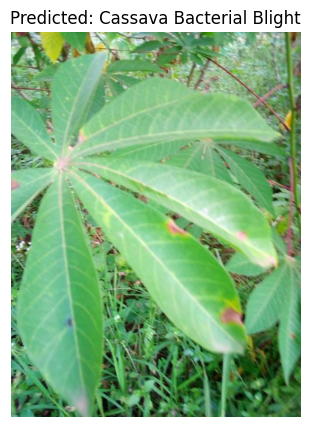

In [22]:
# Data augmentation / preprocessing
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
test_val_transforms = transforms.Compose([
    transforms.Resize(400),
    transforms.CenterCrop(380),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Custom dataset class
class TestDataset(Dataset):
    def __init__(self, image_dir=None, image_path=None, transform=None):
        # Either a folder or single image
        if image_dir:
            self.image_paths = sorted(glob.glob(os.path.join(image_dir, "*.jpg")))
        elif image_path:
            self.image_paths = [image_path]
        else:
            raise ValueError("Provide either image_dir or image_path")
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.image_paths[idx]

# Load single image via dataset
img_path = "../docs/test_image/train-cbb-0.jpg"
dataset = TestDataset(image_path=img_path, transform=test_val_transforms)
img_tensor, _ = dataset[0]  # img_tensor shape: (3, 380, 380)

# Convert to NumPy and add batch dimension for TFLite
img_array = img_tensor.numpy()[np.newaxis, :, :, :]  # shape: (1, 3, 380, 380)

# Run TFLite inference
interpreter = tf.lite.Interpreter(model_path="../models/cassava_model.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.set_tensor(input_details[0]['index'], img_array.astype(np.float32))
interpreter.invoke()
logits = interpreter.get_tensor(output_details[0]['index'])

# Softmax
probs = np.exp(logits)/np.sum(np.exp(logits), axis=1, keepdims=True)
pred_class = np.argmax(probs, axis=1)[0]

cassava_labels = [
    "Cassava Bacterial Blight",
    "Cassava Brown Streak Disease",
    "Cassava Green Mottle",
    "Cassava Mosaic Disease",
    "Healthy"
]

print("Predicted label:", cassava_labels[pred_class])
print("Probabilities:", probs)

# Plot image with prediction
plt.figure(figsize=(5,5))
plt.imshow(Image.open(img_path))
plt.axis('off')
plt.title(f"Predicted: {cassava_labels[pred_class]}")
plt.show()
